Test Methods for adding noise to audio

In [1]:
%matplotlib widget
from transformers import WhisperFeatureExtractor
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import librosa
from tqdm.notebook import tqdm
from threading import Thread

In [2]:
seed = 0
rng = np.random.default_rng(seed)
noise_dir = 'datasets/noise'
alphadigit_single_dir = 'datasets/alphadigit_letters'
alphadigit_dir = 'datasets/cslu_alphadigits_LDC2008S06'
local_dir = 'datasets/local_sloans'

In [3]:
rng.random()

0.6369616873214543

In [4]:
audio_formats = ['.wav', '.m4a', '.mp3']
def get_audio_paths(dir):
    audio_paths = []
    for filename in os.listdir(dir):
        extension = os.path.splitext(filename)[-1]
        if extension == '':
            sub_audio_paths = get_audio_paths(os.path.join(dir, filename))
            for path in sub_audio_paths:
                audio_paths.append(path)
        elif extension in audio_formats:
            file_path = os.path.join(dir, filename)
            audio_paths.append(file_path)
    return audio_paths
    
def prune_long_audio(audio_paths, max_length=5):
    new_audio_paths = []
    for audio_path in tqdm(audio_paths):
        audio_array, sr = librosa.load(audio_path)
        if librosa.get_duration(y=audio_array, sr=sr) <= max_length:
            new_audio_paths.append(audio_path)
    return new_audio_paths

In [5]:
audio_paths = get_audio_paths(local_dir)
print(f'Total Audio: {len(audio_paths)}')
audio_paths = prune_long_audio(audio_paths)
print(f'Pruned Audio: {len(audio_paths)}')

noise_paths = get_audio_paths(noise_dir)

Total Audio: 490


  0%|          | 0/490 [00:00<?, ?it/s]

Pruned Audio: 490


In [6]:
def add_noise_raw(signal_array, noise_array):
    signal_len = len(signal_array)
    noise_len = len(noise_array)

    gap = noise_len - signal_len
    start = rng.integers(low=0, high=gap+1, size=1)[0]
    return signal + noise[start:start+signal_len]

def extract_file_features(audio_paths, result_mfccs, id):
    feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')
    for audio_path in tqdm(audio_paths, desc=id):
        audio_array, sr = librosa.load(audio_path)

        # Convert to 16k sample rate
        if sr != 16000:
            audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
            sr = 16000

        mfcc = feature_extractor(audio_array, sampling_rate=sr)
        result_mfccs.append(mfcc)

# Split array into n parts
def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def extract_file_features_multiproc(audio_paths, num_proc=10):
    audio_path_splits = split(audio_paths, num_proc)

    threads = []
    result_mfccs = []
    for proc in range(num_proc):
        result_mfccs.append([])
        t_temp = Thread(target=extract_file_features, args=(audio_path_splits[proc], result_mfccs[proc], str(proc)))
        t_temp.start()
        
        threads.append(t_temp)

    total_mfccs = []
    for proc in range(num_proc):
        threads[proc].join()
        for mfcc in result_mfccs[proc]:
            total_mfccs.append(mfcc)
    return total_mfccs

In [7]:
audio_mfccs = extract_file_features_multiproc(audio_paths, 2)
noise_mfccs = extract_file_features_multiproc(noise_paths, 2)

0:   0%|          | 0/245 [00:00<?, ?it/s]

1:   0%|          | 0/245 [00:00<?, ?it/s]

KeyboardInterrupt: 

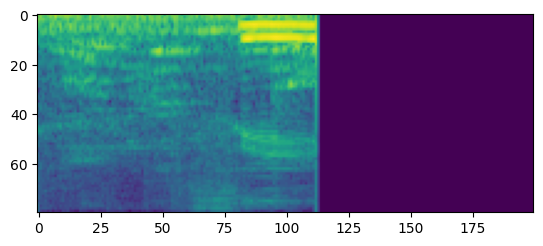

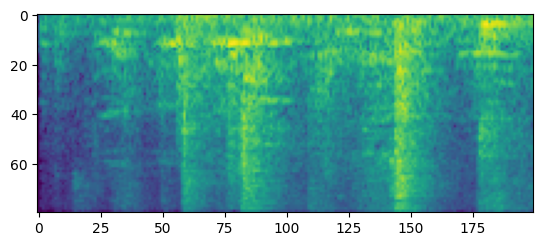

In [8]:
plt.imshow(audio_mfccs[0]['input_features'][0][:, :200])
plt.show()
plt.imshow(noise_mfccs[0]['input_features'][0][:, :200])
plt.show()

In [12]:
class AudioLabel:
    def __init__(self, start, end, label):
        self.label = label
        self.start = start
        self.end = end

    def duration(self):
        return self.end - self.start

    def __len__(self):
        return self.duration()

    def __repr__(self):
        return f'AudioLabel(start={self.start}, end={self.end}, label={self.label})'
    def __str__(self):
        return self.__repr__()

class LabeledAudio:
    def __init__(self, phn_path, txt_path, audio_path):
        self.phn_labels = []
        with open("datasets/cslu_alphadigits_LDC2008S06/cslu_alphadigits/labels/0/AD-1.getid.phn", "r") as f:
            for idx, phn_string in enumerate(f):
                if idx >= 2:
                    phn_string = phn_string.strip()
                    phn_parts = phn_string.split(' ')
                    phn_labels.append(AudioLabel(int(phn_parts[0]), int(phn_parts[1]), phn_parts[2]))
                

NameError: name 'phn_labels' is not defined

In [14]:
def parse_phn_line(phn_sting):
    phn_string = phn_string.strip()
    if phn_string == '':
        return {}
    phn_parts = phn_string.split(' ')
    if phn_parts[0][0] == 'M':
        return {'Frame Duration': float(phn_parts[1])}
    if phn_parts[0][1] == 'E':
        return {}
    else:
        return AudioLabel(phn_parts)


    print(f.readline())

print(phn_labels)

NameError: name 'phn_labels' is not defined

In [6]:
def parse_alphadigit_phn(phn_path):
    label = []
    with open(phn_path, 'r') as f:
        for idx, phn_string in enumerate(f):
            if idx >= 2:
                components = phn_string.strip().split(' ')
                start = int(components[0])
                stop = int(components[1])
                phoneme = components[2]
                label.append({
                    'start': start,
                    'stop': stop,
                    'phoneme': phoneme
                })
    return label
def parse_alphadigit_txt(txt_path):
    label = []
    with open(txt_path, 'r') as f:
        return f.readline().strip().split(' ')
def get_alphadigit_data(folder_path):
    labeled_audio_list = []
    
    letter_folder = 'trans'
    audio_folder = 'speech'
    phonetic_folder = 'labels'

    count = 0
    audio_folder_path = os.path.join(folder_path, audio_folder)
    for subfolder in os.listdir(audio_folder_path):
        subfolder_path = os.path.join(audio_folder_path, subfolder)
        for audio_file in os.listdir(subfolder_path):
            count += 1
    print(count)
    pbar = tqdm(total=count)
    
    audio_folder_path = os.path.join(folder_path, audio_folder)
    for subfolder in os.listdir(audio_folder_path):
        subfolder_path = os.path.join(audio_folder_path, subfolder)
        for audio_file in os.listdir(subfolder_path):
            filename = audio_file[:-4]

            letter_path = os.path.join(folder_path, letter_folder, subfolder, filename + '.txt')
            phonetic_path = os.path.join(folder_path, phonetic_folder, subfolder, filename + '.phn')

            audio_path = os.path.join(folder_path, audio_folder, subfolder, audio_file)
            try:
                phonetic_label = parse_alphadigit_phn(phonetic_path)
                letter_label = parse_alphadigit_txt(letter_path)

                labeled_audio_list.append({
                    'name': filename,
                    'subfolder': subfolder,
                    'audio_path': audio_path,
                    'phonetic_label': phonetic_label,
                    'letter_label': letter_label,
                })
            except:
                print(f'Cannot find .phn or .txt for {filename}')
            pbar.update(1)
    return labeled_audio_list
    
labeled_audio_list = get_alphadigit_data('datasets/cslu_alphadigits_LDC2008S06/cslu_alphadigits')

78044


  0%|          | 0/78044 [00:00<?, ?it/s]

In [7]:
labeled_audio_list

[{'name': 'AD-1.getid',
  'subfolder': '0',
  'audio_path': 'datasets/cslu_alphadigits_LDC2008S06/cslu_alphadigits\\speech\\0\\AD-1.getid.wav',
  'phonetic_label': [{'start': 0, 'stop': 75, 'phoneme': '.pau'},
   {'start': 75, 'stop': 160, 'phoneme': 'w'},
   {'start': 160, 'stop': 210, 'phoneme': '^'},
   {'start': 210, 'stop': 520, 'phoneme': 'n'},
   {'start': 520, 'stop': 670, 'phoneme': 'z'},
   {'start': 670, 'stop': 880, 'phoneme': 'I'},
   {'start': 880, 'stop': 965, 'phoneme': '9r'},
   {'start': 965, 'stop': 1065, 'phoneme': 'oU'},
   {'start': 1065, 'stop': 1355, 'phoneme': '.pau'},
   {'start': 1355, 'stop': 1555, 'phoneme': 'ei'},
   {'start': 1555, 'stop': 1710, 'phoneme': 'tc'},
   {'start': 1710, 'stop': 1775, 'phoneme': 'th'},
   {'start': 1775, 'stop': 2960, 'phoneme': '.pau'}],
  'letter_label': ['one', 'zero', 'eight']},
 {'name': 'AD-1.p1',
  'subfolder': '0',
  'audio_path': 'datasets/cslu_alphadigits_LDC2008S06/cslu_alphadigits\\speech\\0\\AD-1.p1.wav',
  'phonet

In [8]:
def get_letter_labels(labeled_audio_list):
    letter_list = set()
    for labeled_audio in tqdm(labeled_audio_list):
        for letter in labeled_audio['letter_label']:
            letter_list.add(letter)
    return list(letter_list)

def get_phoneme_labels(labeled_audio_list):
    phoneme_list = set()
    for labeled_audio in tqdm(labeled_audio_list):
        for phoneme in labeled_audio['phonetic_label']:
            phoneme_list.add(phoneme['phoneme'])
    return list(phoneme_list)
letters = get_letter_labels(labeled_audio_list)
phonemes = get_phoneme_labels(labeled_audio_list)

  0%|          | 0/78044 [00:00<?, ?it/s]

  0%|          | 0/78044 [00:00<?, ?it/s]

In [9]:
sloan_letters = ['c', 'd', 'h', 'k', 'n', 'o', 'r', 's', 'v', 'z']
phonemes

['oU',
 'E',
 '.laugh',
 'd_(',
 'T',
 'dc',
 '.cough',
 '&',
 'g',
 'ei',
 '.ls',
 'A',
 'ph',
 '.sniff',
 'j',
 'U',
 'bc',
 '.tc',
 '.br',
 '.sneeze',
 's',
 '.fp',
 'S',
 '^',
 'w',
 '3r',
 'kc',
 '.pau',
 'aU',
 'dZc',
 'tc',
 'f',
 'gc',
 '9r',
 '@',
 'n',
 'z',
 'D',
 'I',
 'v',
 'dZ',
 '.ct',
 'th',
 'aI',
 'b',
 'h',
 'tS',
 '>',
 '>i',
 'd',
 'tSc',
 'u',
 'kh',
 'm',
 '.burp',
 'pc',
 'i:',
 'N',
 'l']

In [10]:
len(phonemes)

59

In [11]:
from src.configs import WflcConfigs

In [12]:
WflcConfigs.get_config('wflc_tiny_phonetics')

{'model_name': 'WhisperForLetterClassification_Tiny',
 'pretrained_whisper': 'openai/whisper-tiny',
 'audio_config': {'sample_rate': 16000, 'window_length': 1500},
 'encoder': {'module_list': ['whisper.encoder']},
 'projector': {'module_list': ['whisper.projector']},
 'classifier': {'module_list': [{'name': 'Linear',
    'kwargs': {'in_features': 256, 'out_features': 59, 'bias': True}}]}}

In [13]:
labeled_audio_list[0]

{'name': 'AD-1.getid',
 'subfolder': '0',
 'audio_path': 'datasets/cslu_alphadigits_LDC2008S06/cslu_alphadigits\\speech\\0\\AD-1.getid.wav',
 'phonetic_label': [{'start': 0, 'stop': 75, 'phoneme': '.pau'},
  {'start': 75, 'stop': 160, 'phoneme': 'w'},
  {'start': 160, 'stop': 210, 'phoneme': '^'},
  {'start': 210, 'stop': 520, 'phoneme': 'n'},
  {'start': 520, 'stop': 670, 'phoneme': 'z'},
  {'start': 670, 'stop': 880, 'phoneme': 'I'},
  {'start': 880, 'stop': 965, 'phoneme': '9r'},
  {'start': 965, 'stop': 1065, 'phoneme': 'oU'},
  {'start': 1065, 'stop': 1355, 'phoneme': '.pau'},
  {'start': 1355, 'stop': 1555, 'phoneme': 'ei'},
  {'start': 1555, 'stop': 1710, 'phoneme': 'tc'},
  {'start': 1710, 'stop': 1775, 'phoneme': 'th'},
  {'start': 1775, 'stop': 2960, 'phoneme': '.pau'}],
 'letter_label': ['one', 'zero', 'eight']}

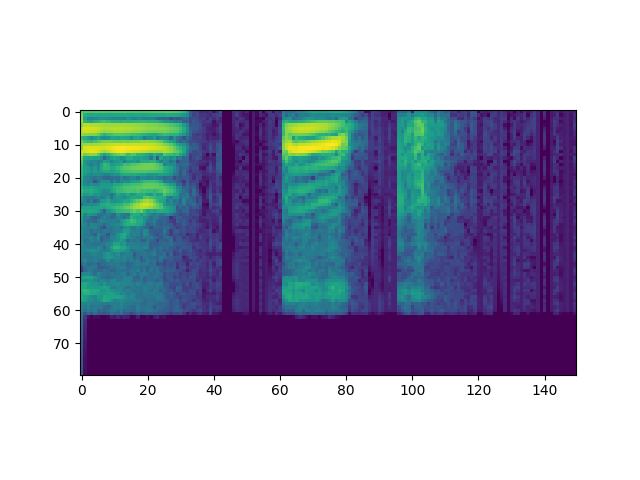

['I', '9r', 'oU', '.pau', 'ei', 'tc', 'th', '.pau']


In [31]:
seed = 0
rng = np.random.default_rng(seed)
feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')

def get_random_section(slice_length, total_length):
    slice_start = rng.integers(low=0, high=total_length-int(slice_length))
    slice_end = slice_start + int(slice_length)
    return slice_start, slice_end
    
def cut_audio(audio_path, slice_length, phonetic_label):
    rng.random()
    audio_array, sr = librosa.load(audio_path)
    # print(len(audio_array))
    # Convert to 16k sample rate
    if sr != 16000:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
        sr = 16000

    total_length = len(audio_array)
    slice_start, slice_end = get_random_section(sr*slice_length/1000, total_length)
    audio_slice = audio_array[slice_start:slice_end]
    mfcc = feature_extractor(audio_slice, sampling_rate=sr)['input_features'][0][:,:int(slice_length/10)]

    slice_phonetics = []
    found_start = False
    exit = False
    idx = 0
    for phoneme in phonetic_label:
        if not found_start:
            if phoneme['stop']*sr/1000 > slice_start:
                found_start = True
        if found_start:
            if phoneme['start']*sr/1000 > slice_end:
                exit = True
            if not exit:
                slice_phonetics.append(phoneme['phoneme'])

        if exit:
            break
    return mfcc, slice_phonetics
mfcc, phonetic_label = cut_audio(labeled_audio_list[0]['audio_path'], 1500, labeled_audio_list[0]['phonetic_label'])
plt.imshow(mfcc)
plt.show()
print(phonetic_label)
# get_random_section(1500, 15000)

In [33]:
def onehot_encode(label, total_labels):
    onehot_label = np.zeros(len(total_labels))
    for phoneme in label:
        idx = total_labels.index(phoneme)
        onehot_label[idx] = 1
    return onehot_label

def onehot_decode(onehot_label, total_labels):
    label = []
    for idx, value in enumerate(onehot_label):
        if value:
            label.append(total_labels[idx])
    return label
onehot_decode(onehot_encode(phonetic_label, phonemes), phonemes)

['oU', 'ei', '.pau', 'tc', '9r', 'I', 'th']

In [49]:
from torch.utils.data import Dataset
import torch

class PhoneticDataset(Dataset):
    def __init__(self, labeled_audio_list, num_samples, slice_length, phonemes):
        super().__init__()
        self.mfccs = []
        self.phonemes = phonemes
        self.labels = []
        self.onehot_labels = []

        idx = 0
        pbar = tqdm(total=num_samples)
        while idx < num_samples:
            sample_idx = rng.integers(low=0, high=len(labeled_audio_list))
            try:
                mfcc, phonetic_label = cut_audio(labeled_audio_list[sample_idx]['audio_path'], slice_length, labeled_audio_list[sample_idx]['phonetic_label'])
            except:
                print('Audio Error, retrying')
            else:
                phonetic_label = list(set(phonetic_label))

                self.mfccs.append(torch.tensor(mfcc).cuda())
                self.labels.append(phonetic_label)
                self.onehot_labels.append(torch.tensor(onehot_encode(phonetic_label, phonemes)).cuda())

                idx += 1
                pbar.update(1)
    def __getitem__(self, idx):
        return self.mfccs[idx], self.onehot_labels[idx]
    
    def __len__(self):
        return len(self.mfccs)
dataset= PhoneticDataset(labeled_audio_list, 100, 1500, phonemes)

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
len(dataset)

100

In [52]:
from src.models import ModelUtils, WhisperForLetterClassification

wflc_small_config = WflcConfigs.get_config('wflc_tiny_phonetics')
wflc_small = WhisperForLetterClassification(wflc_small_config)
wflc_small = wflc_small.to(device='cuda:0')

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['model.classifier.weight', 'model.classifier.bias', 'model.projector.weight', 'model.projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
WflcConfigs.get_config('wflc_tiny_phonetics')

{'model_name': 'WhisperForLetterClassification_Tiny',
 'pretrained_whisper': 'openai/whisper-tiny',
 'audio_config': {'sample_rate': 16000, 'window_length': 1500},
 'encoder': {'module_list': ['whisper.encoder']},
 'projector': {'module_list': ['whisper.projector']},
 'classifier': {'module_list': [{'name': 'Linear',
    'kwargs': {'in_features': 256, 'out_features': 59, 'bias': True}}]}}

In [55]:
wflc_small.forward(torch.unsqueeze(dataset[0][0], 0))

tensor([[ 0.2497,  0.2361, -0.0089,  0.1932,  0.2819, -0.0930, -0.4745, -0.1378,
         -0.0758, -0.2042,  0.0533,  0.0175, -0.0517, -0.0868,  0.2779,  0.2286,
         -0.0152, -0.1341,  0.1883, -0.2259,  0.5109,  0.2301, -0.1810, -0.2820,
         -0.2569,  0.1823,  0.1441,  0.1531,  0.1539,  0.1934,  0.0162,  0.0088,
          0.3486,  0.3318,  0.2101,  0.1678,  0.0516,  0.1685,  0.1313,  0.0934,
          0.2901, -0.0212, -0.1433,  0.0514,  0.2131,  0.2047, -0.2910,  0.1227,
          0.1045,  0.0873,  0.1389, -0.1938, -0.5883,  0.0790, -0.3284, -0.3596,
          0.3200, -0.4542,  0.2233]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [56]:
from torch.utils.data import DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [78]:
import importlib
import src.trainer
importlib.reload(src.trainer)

from src.trainer import eval_model, train_phonetics
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(wflc_small.parameters(), lr=0.001, weight_decay=0.0001)

In [79]:
loss = train_phonetics(wflc_small, train_dataloader, val_dataloader, criterion, optimizer)






Training:   0%|                                                                                | 0/100 [00:11<?, ?it/s]


IndexError: list index out of range